## <div align=center>Diversity vs. Human Development Analysis Project</div>
### <div align=center>Connor Collins, Andrew Nguyen</div>
### <div align=center>OMIS 114</div>
### <div align=center>1 December 2020</div>

### <div align=center>In western civilization, it is often said by various activists, pundits and politicians that "diversity is our strength," implying that a higher level of diversity in a given nation is indicative or a contributing factor to economic prosperity and/or a higher standard of living.  This study will attempt to examine the truth of such a claim by comparing UN Human Development Index (HDI) data of a given nation with their level of ethnic diversity (measured in Ethnic Fractionalization Index or EFI) to see if there is any correlation.  Afterwards, we will compare EFI with the each individual subcomponent of HDI (such as Economy, Education, etc) to see if there are any correlations in specific aspects of HDI. Additionally we will compare EFI with a country's level of happiness (UN Happiness Index) as we believe collective happiness ought to be a factor in a country's quality of life.  </div>

In [188]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib.ticker as ticker
import matplotlib as mpl
import numpy as np
from functools import reduce
from sklearn import linear_model
pd.set_option('display.max_rows', None, 'display.max_columns', None)

## Loading the Data

### Summary of data used in this project (in order of invocation):

###### <u>United Nations Data:</u>
<ul>
    <li>      <b>Human Development Index (HDI)</b>:  measures a country's level of human development as a composite of the variables below (Higher = Better)<br>
        <ul><li>       <b>Schooling Years</b>:  measures the average length of schooling for a given country (Higher = Better)<br>
            <li>       <b>Exports + Imports</b>:  measures openess to trade by summing a country's Exports and Imports as a percentage of their GDP ((Higher = Better)<br>
            <li>       <b>Gender Development Index</b>: measures the HDI-sex-gap using a ratio between Males-only HDI and Females-only HDI (Lower = Better)<br>
 <li>      <b>Gross National Income (per capita)</b>: aka Purchasing Power Parity (PPP), GNI measures the spending power of an average person in a given country in raw dollar terms (Higher = Better)<br>
 <li>     <b>Inequality-adjusted HDI</b>: measures inequality by producing an HDI score adjusted for inequality (Higher = Better)<br>
 <li>       <b>Internet Users</b>: measures mobility and communication through the percentage of people who have internet access (Higher = Better)<br>
 <li>       <b>Life Expectancy</b>:  measures human security through the average life expectancy of a country (Higher = Better)<br>
 <li>      <b>Population</b>:  measures demography via the total population of a country in millions (Higher = More Crowded)<br>
 <li>       <b>Skilled Labor</b>: measures socio-economic stability by seeing how much of the labor force is skilled (Higher = Better)<br>
 <li>      <b>Employment</b>: measures the percentage of the population that is employed (Higher = Better, mostly)<br>
 <li>       <b>Homicide Rate</b>: measures human security by capturing the number of homicides per 100k people (Lower = Better)<br>
 <li>      <b>World Happiness Report</b>: measures a country's level of self-reported happiness (Higher = Better)<br>
     </ul>
</ul>

##### <u>Harvard Data:</u>
<ul>
    <li> <b>Historical Index of Ethnic Fractionalization (HIEF)</b>: measures a country's level of diversity (Higher score = More diverse) <br>
<ul>

In [2]:
hdi=pd.read_csv('Human Development Index (HDI).csv')
hief_data=pd.read_csv('HIEF_data.csv')

schooling_years=pd.read_csv('Expected years of schooling (years).csv')
exports_imports=pd.read_csv('Exports and imports (% of GDP).csv')
gender_development=pd.read_csv('Gender Development Index (GDI).csv')
gni_per_capita=pd.read_csv('Gross national income (GNI) per capita (2011 PPP$).csv')
homicide_rate=pd.read_csv('Homicide rate (per 100,000 people).csv')
inequality=pd.read_csv('Inequality-adjusted HDI (IHDI).csv')
internet_users=pd.read_csv('Internet users, total (% of population).csv')
life_exp=pd.read_csv('Life expectancy at birth.csv')
population=pd.read_csv('Population, total (millions).csv')
skilled_labor=pd.read_csv('Skilled labour force (% of labour force).csv')
employment=pd.read_csv('Employment to population ratio (% ages 15 and older).csv')

whr=pd.read_excel('WHR20_DataForFigure2.1.xls')

data_frames=[schooling_years, exports_imports, gender_development, gni_per_capita, homicide_rate, inequality, 
            internet_users, life_exp, population, skilled_labor, employment]

In [3]:
hief_data=hief_data.loc[hief_data['Year']==2013]

## Cleaning

In [4]:
def fix_csv(csv):
    csv.reset_index(inplace=True)
    new_headers=csv.iloc[0]
    csv.columns=new_headers
    csv.drop(index=0, inplace=True)
    csv=csv.loc[:, csv.columns.notnull()]
    csv=csv.loc[csv['2013']!='..'] # for some reason this also doesn't work inside the function
    #csv.dropna(axis=0, inplace=True)
    
def clean_columns(csv):
    #can't seem to get this to work in a function - gonna do it manually for now, will try to fix later
    csv=csv.loc[:, csv.columns.notnull()]

In [5]:
fix_csv(schooling_years)
fix_csv(exports_imports)
fix_csv(gender_development)
fix_csv(gni_per_capita)
fix_csv(homicide_rate)
fix_csv(inequality)
fix_csv(internet_users)
fix_csv(life_exp)
fix_csv(population)
fix_csv(skilled_labor)
fix_csv(employment)
fix_csv(hdi)

Problem: Dataframes pertaining to HDI and HDI subcomponents have lots of useless data under Zimbabwe

Assumptions:
<ul>
<li>All UN HDI dataframes already arranged their countries in alphabetical order
<li>Zimbabwe should, therefore, always be the last data entry in any HDI-related dataframe
</ul>

Solution: Make a function that captures the index of a given DataFrame's 'Zimbabwe' entry and drop every entry after it

In [6]:
## .index on a DataFrame returns an int64, which can't be used in index range operations.
## We must thus convert the int64 into an int.
## Using .tolist()[0] effectively achieves this.
## We now have a new function that cleans up HDI data after Zimbabwe.

def zim_index_drop(df):
    zim_index = df[df.Country == 'Zimbabwe'].index.tolist()[0]
    df = df.drop(df.index[(zim_index + 1):], inplace=True)
    
def zim_index_find(df):
    zim_index = df[df.Country == 'Zimbabwe'].index.tolist()[0]
    return zim_index

In [7]:
zim_index_drop(hdi)
zim_index_drop(schooling_years)
zim_index_drop(exports_imports)
zim_index_drop(gender_development)
zim_index_drop(gni_per_capita)
zim_index_drop(homicide_rate)
zim_index_drop(inequality)
zim_index_drop(internet_users)
zim_index_drop(life_exp)
zim_index_drop(population)
zim_index_drop(skilled_labor)
zim_index_drop(employment)

In [8]:
hdi = hdi.loc[:, hdi.columns.notnull()].loc[hdi['2013']!='..'].loc[hdi['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
schooling_years = schooling_years.loc[:, schooling_years.columns.notnull()].loc[schooling_years['2013']!='..'].loc[schooling_years['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
exports_imports = exports_imports.loc[:, exports_imports.columns.notnull()].loc[exports_imports['2013']!='..'].loc[exports_imports['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
gender_development = gender_development.loc[:, gender_development.columns.notnull()].loc[gender_development['2013']!='..'].loc[gender_development['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
gni_per_capita = gni_per_capita.loc[:, gni_per_capita.columns.notnull()].loc[gni_per_capita['2013']!='..'].loc[gni_per_capita['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
homicide_rate = homicide_rate.loc[:, homicide_rate.columns.notnull()].loc[homicide_rate['2013']!='..'].loc[homicide_rate['2017']!='..'][['HDI Rank (2018)', 'Country', '2013', '2017']]
inequality = inequality.loc[:, inequality.columns.notnull()].loc[inequality['2013']!='..'].loc[inequality['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
internet_users = internet_users.loc[:, internet_users.columns.notnull()].loc[internet_users['2013']!='..'].loc[internet_users['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
life_exp = life_exp.loc[:, life_exp.columns.notnull()].loc[life_exp['2013']!='..'].loc[life_exp['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
population = population.loc[:, population.columns.notnull()].loc[population['2013']!='..'].loc[population['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
skilled_labor = skilled_labor.loc[:, skilled_labor.columns.notnull()].loc[skilled_labor['2013']!='..'].loc[skilled_labor['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
employment = employment.loc[:, employment.columns.notnull()].loc[employment['2013']!='..'].loc[employment['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]

Naming Convention for UN Data:

 hdi:      Human Development Index score <br>
 sy:       Schooling Years <br>
 ei:       Exports + Imports (percentage of GDP) <br>
 gd:       Gender Development Index<br>
 gni:      Gross National Income (per capita)<br>
 ineq:     Inequality-adjusted HDI<br>
 iu:       Internet Users (as % of pop)<br>
 le:       Life Expectancy<br>
 pop:      Population<br>
 sl:       Skilled Labor (as % of labor force)<br>
 emp:      Employment (ratio to pop)<br>
 hr:       Homicide Rate<br>
 

In [9]:
hdi.rename(columns={'2013':'hdi_2013', '2018':'hdi_2018'}, inplace=True)
schooling_years.rename(columns={'2013':'sy_2013', '2018':'sy_2018'}, inplace=True)
exports_imports.rename(columns={'2013':'ei_2013', '2018':'ei_2018'}, inplace=True)     
gender_development.rename(columns={'2013':'gd_2013', '2018':'gd_2018'}, inplace=True)
gni_per_capita.rename(columns={'2013':'gni_2013', '2018':'gni_2018'}, inplace=True)
inequality.rename(columns={'2013':'ineq_2013', '2018':'ineq_2018'}, inplace=True)
internet_users.rename(columns={'2013':'iu_2013', '2018':'iu_2018'}, inplace=True)
life_exp.rename(columns={'2013':'le_2013', '2018':'le_2018'}, inplace=True)
population.rename(columns={'2013':'pop_2013', '2018':'pop_2018'}, inplace=True)
skilled_labor.rename(columns={'2013':'sl_2013', '2018':'sl_2018'}, inplace=True)
employment.rename(columns={'2013':'emp_2013', '2018':'emp_2018'}, inplace=True)
homicide_rate.rename(columns={'2013':'hr_2013', '2017':'hr_2018'}, inplace=True)
#There is no data for 2018 in homicide_rate so I think it makes the most sense to just use 2017 for 2018

In [10]:
hief_data=hief_data[['Country', 'EFindex']]

In [11]:
hief_data = hief_data.rename(columns={"EFindex":"EFIndex_2013"})

In [12]:
## This sorts the countries by alphabetical order, to better align the datasets
hief_data = hief_data.sort_values('Country')

In [13]:
## This resets the index numbering of the dataset by creating an additional column to the left.
hief_data = hief_data.reset_index()

In [14]:
## This deletes the old index column
hief_data = hief_data.drop(columns=['index'])

In [15]:
## Clean
#hief_data

In [16]:
#hdi

In [17]:
whr=whr[['Country name', 'Ladder score']].rename(columns={'Country name': 'Country'})

In [18]:
## using 'inner' will merge all matching country names AND remove ALL NaN's
## using 'outer' will merge all matching countries and add additional rows for non-matching ones, resulting in many NaN's
hdi_w_hief=hdi.merge(hief_data, how='outer')

In [19]:
## Scroll to the bottom after index 188 to see a problem
hdi_w_hief

,HDI Rank (2018),Country,hdi_2013,hdi_2018,EFIndex_2013
0,170,Afghanistan,0.485,0.496,0.763
1,69,Albania,0.781,0.791,0.139
2,82,Algeria,0.746,0.759,0.372
3,36,Andorra,0.846,0.857,NaN
4,149,Angola,0.547,0.574,0.779
5,74,Antigua and Barbuda,0.767,0.776,NaN
6,48,Argentina,0.824,0.830,0.158
7,81,Armenia,0.743,0.760,0.045
8,6,Australia,0.926,0.938,0.276
9,20,Austria,0.896,0.914,0.248


In [20]:
hdi_w_hief.isna().sum()

HDI Rank (2018)    25
Country             0
hdi_2013           25
hdi_2018           25
EFIndex_2013       57
dtype: int64

#### Here we encountered a problem pertaining to naming discrepencies between the EFI data and the UN data.  Here we take an aside from the current analysis at hand in order to fix this problem for our subsequent analysis

In [21]:
## Here the zim_index functions come in handy once again, this time to capture the naming-error countries
lostnats = hdi_w_hief.iloc[zim_index_find(hdi_w_hief) + 1:]

In [22]:
## Out of the 57 countries that are NaN-ed, 25 of them should NOT be
len(lostnats)

25

In [23]:
## This is all the countries we lost due to naming discrepencies between the two datasets.
lostnats

,HDI Rank (2018),Country,hdi_2013,hdi_2018,EFIndex_2013
188,NaN,Bolivia,NaN,NaN,0.572
189,NaN,Bosnia-Herzegovina,NaN,NaN,0.637
190,NaN,Cape Verde,NaN,NaN,0.442
191,NaN,Cote d'Ivoire,NaN,NaN,0.731
192,NaN,Czech Republic,NaN,NaN,0.262
193,NaN,Democratic People's Republic of Korea,NaN,NaN,0.020
194,NaN,Democratic Republic of Congo,NaN,NaN,0.700
195,NaN,Democratic Republic of Vietnam,NaN,NaN,0.263
196,NaN,East Timor,NaN,NaN,0.802
197,NaN,German Federal Republic,NaN,NaN,0.189


In [24]:
## Here we generate the lists of country names to be renamed
EFI_names = lostnats.Country.tolist()
UN_names = ["Bolivia (Plurinational State of)", "Bosnia and Herzegovina", 
            "Cabo Verde", "Côte d'Ivoire", "Czechia", "EXCLUDE NORTH KOREA", 
            "Congo (Democratic Republic of the)", "Viet Nam", "Timor-Leste", 
            "Germany", "Iran (Islamic Republic of)", "Kyrgyzstan", "Lao People's Democratic Republic", 
            "North Macedonia", "Moldova (Republic of)", "Korea (Republic of)", "Russian Federation", 
            "EXCLUDE SOMALIA", "Eswatini (Kingdom of)", "Syrian Arab Republic", 
            "No Taiwan...suspicious *cough*China*cough*", "Tanzania (United Republic of)", 
            "United States", "Venezuela (Bolivarian Republic of)", "Yemen"]

In [25]:
## Here we verify that the number of EFI countries to be renamed total 25
len(EFI_names)

25

In [26]:
## Here we verify that the number of UN countries total 25
len(UN_names)

25

In [27]:
## Here the EFI countries are being renamed to conform with the UN naming conventions.
hief_data_renamed = hief_data.replace(EFI_names, UN_names)

In [28]:
## This will be the hief_data being used going forward
len(hief_data_renamed)
len(whr)

153

In [29]:
hdi_w_hief = hdi.merge(hief_data_renamed, how='left')

In [30]:
hdi_w_hief

,HDI Rank (2018),Country,hdi_2013,hdi_2018,EFIndex_2013
0,170,Afghanistan,0.485,0.496,0.763
1,69,Albania,0.781,0.791,0.139
2,82,Algeria,0.746,0.759,0.372
3,36,Andorra,0.846,0.857,NaN
4,149,Angola,0.547,0.574,0.779
5,74,Antigua and Barbuda,0.767,0.776,NaN
6,48,Argentina,0.824,0.830,0.158
7,81,Armenia,0.743,0.760,0.045
8,6,Australia,0.926,0.938,0.276
9,20,Austria,0.896,0.914,0.248


In [31]:
hdi_w_hief.reset_index()

,index,HDI Rank (2018),Country,hdi_2013,hdi_2018,EFIndex_2013
0,0,170,Afghanistan,0.485,0.496,0.763
1,1,69,Albania,0.781,0.791,0.139
2,2,82,Algeria,0.746,0.759,0.372
3,3,36,Andorra,0.846,0.857,NaN
4,4,149,Angola,0.547,0.574,0.779
5,5,74,Antigua and Barbuda,0.767,0.776,NaN
6,6,48,Argentina,0.824,0.830,0.158
7,7,81,Armenia,0.743,0.760,0.045
8,8,6,Australia,0.926,0.938,0.276
9,9,20,Austria,0.896,0.914,0.248


In [32]:
df_minus_whr=hdi_w_hief.merge(schooling_years, how='left').merge(gender_development, how='left').merge(gni_per_capita, 
    how='left').merge(homicide_rate, how='left').merge(inequality, how='left').merge(internet_users, how='left'
    ).merge(life_exp, how='left').merge(population, how='left').merge(skilled_labor, how='left'
    ).merge(employment, how='left').merge(exports_imports, how='left')

whr_to_fix=df_minus_whr.merge(whr, how='outer')

In [33]:
lostnats2 = whr_to_fix.iloc[zim_index_find(whr_to_fix) + 1:]
WHR_names=lostnats2.Country.tolist()
WHR_names

['Czech Republic',
 'Taiwan Province of China',
 'Kosovo',
 'South Korea',
 'Bolivia',
 'Moldova',
 'Russia',
 'North Cyprus',
 'Hong Kong S.A.R. of China',
 'Vietnam',
 'Ivory Coast',
 'Congo (Brazzaville)',
 'Macedonia',
 'Venezuela',
 'Laos',
 'Iran',
 'Palestinian Territories',
 'Congo (Kinshasa)',
 'Swaziland',
 'Tanzania']

In [34]:
whr.replace({'Czech Republic':'Czechia', 'South Korea':'Korea (Republic of)', 'Bolivia':'Bolivia (Plurinational State of)', 
            'Moldova':'Moldova (Republic of)', 'Russia':'Russian Federation', 'Vietnam':'Viet Nam', 'Ivory Coast':
            'Côte d\'Ivoire', 'Macedonia':'North Macedonia', 'Venezuela':'Venezuela (Bolivarian Republic of)', 
            'Laos':'Lao People\'s Democratic Republic', 'Iran':'Iran (Islamic Republic of)', 'Congo (Kinshasha)':
            'Congo', 'Congo (Brazzaville)':'Congo (Democratic Republic of the)', 'Tanzania':'Tanzania (United Republic of)'}, inplace=True)

In [130]:
final_df=df_minus_whr.merge(whr, how='left')
final_df.rename(columns={'Ladder score':'Happiness score'}, inplace=True)

In [131]:
cols_to_make_ints=final_df.columns.drop('Country')
final_df[cols_to_make_ints]=final_df[cols_to_make_ints].astype(float)
final_df.corr()

,HDI Rank (2018),hdi_2013,hdi_2018,EFIndex_2013,sy_2013,sy_2018,gd_2013,gd_2018,gni_2013,gni_2018,hr_2013,hr_2018,ineq_2013,ineq_2018,iu_2013,iu_2018,le_2013,le_2018,pop_2013,pop_2018,sl_2013,sl_2018,emp_2013,emp_2018,ei_2013,ei_2018,Happiness score
HDI Rank (2018),1.000000,-0.987694,-0.989913,0.440290,-0.901057,-0.900856,-0.596199,-0.568903,-0.769137,-0.799287,0.402897,0.371489,-0.980324,-0.983704,-0.873993,-0.835587,-0.887675,-0.897149,0.015200,0.022143,-0.637296,-0.587363,0.181737,0.124640,-0.360517,-0.374882,-0.803718
hdi_2013,-0.987694,1.000000,0.996721,-0.465107,0.903860,0.895588,0.627414,0.594218,0.741226,0.765598,-0.358532,-0.315049,0.980738,0.983234,0.868476,0.846282,0.907182,0.910987,-0.012133,-0.019220,0.633986,0.580846,-0.232044,-0.182608,0.339940,0.351384,0.788822
hdi_2018,-0.989913,0.996721,1.000000,-0.453018,0.904347,0.903965,0.630031,0.604070,0.734262,0.762982,-0.370858,-0.332647,0.977896,0.984590,0.866279,0.844309,0.900597,0.908396,0.001463,-0.005436,0.638070,0.587356,-0.220411,-0.168987,0.346707,0.356594,0.793014
EFIndex_2013,0.440290,-0.465107,-0.453018,1.000000,-0.429574,-0.408891,-0.288524,-0.234449,-0.191427,-0.217268,0.102891,0.074296,-0.555829,-0.549842,-0.157943,-0.072199,-0.512635,-0.516812,-0.042707,-0.034188,-0.438985,-0.375020,0.249211,0.219560,-0.129100,-0.148224,-0.233367
sy_2013,-0.901057,0.903860,0.904347,-0.429574,1.000000,0.984652,0.627840,0.604969,0.591591,0.620910,-0.367879,-0.307301,0.911480,0.909497,0.720809,0.683288,0.791292,0.798943,-0.014530,-0.021012,0.406206,0.403669,-0.185341,-0.136827,0.214021,0.230378,0.736886
sy_2018,-0.900856,0.895588,0.903965,-0.408891,0.984652,1.000000,0.599615,0.580896,0.589199,0.621046,-0.393089,-0.332487,0.902181,0.905674,0.719225,0.684513,0.782079,0.791332,0.001528,-0.004640,0.368628,0.366786,-0.171164,-0.124457,0.219156,0.232789,0.746108
gd_2013,-0.596199,0.627414,0.630031,-0.288524,0.627840,0.599615,1.000000,0.981274,0.396126,0.407912,0.079821,0.101094,0.576178,0.580151,0.513251,0.634259,0.491609,0.510785,-0.063261,-0.070737,0.375643,0.484046,0.009952,0.042842,0.237516,0.271633,0.440424
gd_2018,-0.568903,0.594218,0.604070,-0.234449,0.604969,0.580896,0.981274,1.000000,0.373221,0.386621,0.088022,0.098465,0.539046,0.548320,0.497538,0.621427,0.462482,0.483790,-0.059140,-0.066327,0.346739,0.458956,0.046207,0.078666,0.232795,0.262058,0.436218
gni_2013,-0.769137,0.741226,0.734262,-0.191427,0.591591,0.589199,0.396126,0.373221,1.000000,0.992078,-0.366653,-0.350611,0.857730,0.850106,0.697130,0.723639,0.629218,0.637496,-0.044671,-0.048890,0.469673,0.436450,0.063396,0.098198,0.472221,0.460355,0.731108
gni_2018,-0.799287,0.765598,0.762982,-0.217268,0.620910,0.621046,0.407912,0.386621,0.992078,1.000000,-0.386937,-0.374120,0.865695,0.860203,0.735702,0.743847,0.656819,0.667495,-0.033940,-0.038368,0.498680,0.459319,0.050749,0.092362,0.508320,0.499011,0.750428


# Analysis #1:  EFI vs HDI

#### Iteration #1: EFI 2013 vs HDI 2018

In [470]:
analysis_1=final_df[['hdi_2018', 'EFIndex_2013', 'hdi_2013']].dropna()
analysis_1.corr()
#X=[analysis_1['hdi_2018']]
#Y=[analysis_1['EFIndex_2013']]
#reg=linear_model.LinearRegression()
#reg.fit(X,Y)
#reg.coef_
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

/Users/connorcollins/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


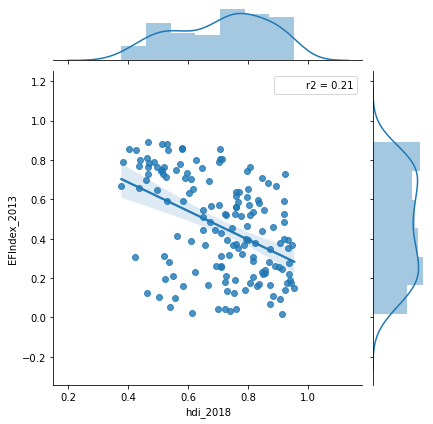

In [467]:
sns.jointplot(data=analysis_1, x='hdi_2018', y='EFIndex_2013', kind='reg', stat_func=r2)

#### Iteration #2: EFI 2013 vs HDI 2013

/Users/connorcollins/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


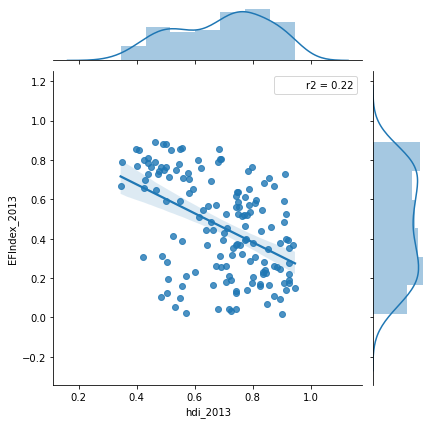

In [469]:
sns.jointplot(data=analysis_1, x='hdi_2013', y='EFIndex_2013', stat_func=r2, kind='reg')

# Analysis #2: EFI vs Years of Schooling (SY)

In [225]:
analysis_2=final_df[['EFIndex_2013', 'sy_2018', 'sy_2013']].dropna()

#### Iteration #1: EFI 2013 vs SY 2018

/Users/connorcollins/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


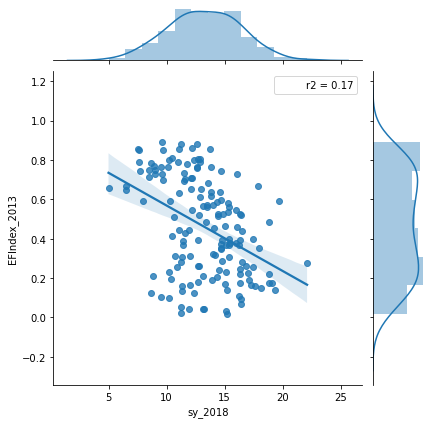

In [471]:
sns.jointplot(data=analysis_2, x='sy_2018', y='EFIndex_2013', stat_func=r2, kind='reg')

#### Iteration #2: EFI 2013 vs SY 2013

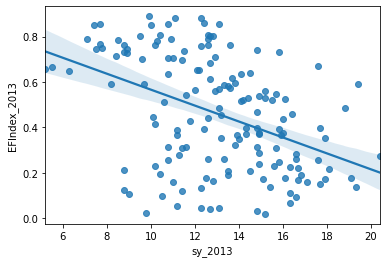

In [228]:
sns.regplot(data=analysis_2, x='sy_2013', y='EFIndex_2013')

# Analysis #3: EFI vs Exports + Imports (EI)

#### Iteration #1:  EFI 2013 vs EI 2018

In [116]:
analysis_3=final_df[['EFIndex_2013', 'ei_2018', 'ei_2013']].dropna()
analysis_3.corr()

,EFIndex_2013,ei_2018,ei_2013
EFIndex_2013,1.000000,-0.148224,-0.129100
ei_2018,-0.148224,1.000000,0.937323
ei_2013,-0.129100,0.937323,1.000000


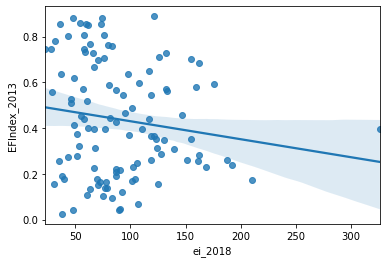

In [473]:
sns.regplot(data=analysis_3, x='ei_2018', y='EFIndex_2013')

#### Iteration #2: EFI 2013 vs EI 2013

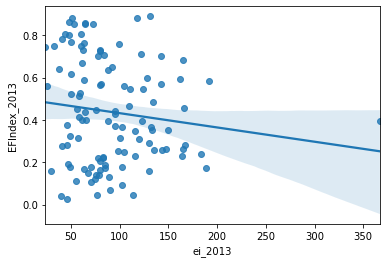

In [220]:
sns.regplot(data=analysis_3, x='ei_2013', y='EFIndex_2013')

# Analysis #4: EFI vs Gender Development (gd)

#### Iteration #1: EFI 2013 vs GD 2018

In [321]:
analysis_4=final_df[['EFIndex_2013', 'gd_2018', 'gd_2013']].dropna()
analysis_4.corr()

,EFIndex_2013,gd_2018,gd_2013
EFIndex_2013,1.000000,-0.240742,-0.280614
gd_2018,-0.240742,1.000000,0.989194
gd_2013,-0.280614,0.989194,1.000000


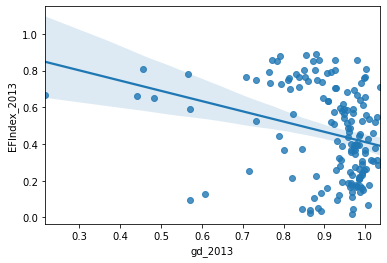

In [322]:
sns.regplot(data=analysis_4, x='gd_2013', y='EFIndex_2013')

#### Iteration #2: EFI 2013 vs GD 2013

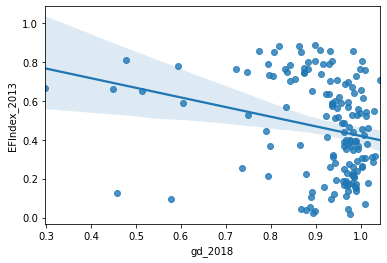

In [324]:
sns.regplot(data=analysis_4, x='gd_2018', y='EFIndex_2013')

# Analysis #5: EFI vs GNI per Capita (GNI)

#### Iteration #1: EFI 2013 vs GNI 2018

In [325]:
analysis_5=final_df[['EFIndex_2013', 'gni_2018', 'gni_2013']].dropna()
analysis_5.corr()

,EFIndex_2013,gni_2018,gni_2013
EFIndex_2013,1.000000,-0.217268,-0.191427
gni_2018,-0.217268,1.000000,0.991283
gni_2013,-0.191427,0.991283,1.000000


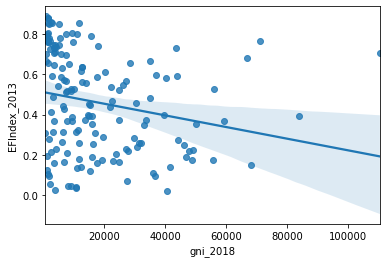

In [328]:
sns.regplot(data=analysis_5, x='gni_2018', y='EFIndex_2013')

#### Iteration #2: EF 2013 vs GNI 2013

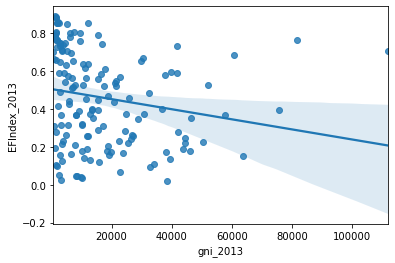

In [329]:
sns.regplot(data=analysis_5, x='gni_2013', y='EFIndex_2013')

# Analysis #6: EFI vs Homicide Rate (HR)

#### Iteration #1: EFI 2013 vs Homicide Rate 2017 (There was no hr data for 2018)

In [330]:
analysis_6=final_df[['EFIndex_2013', 'hr_2018', 'hr_2013']].dropna()
analysis_6.corr()

,EFIndex_2013,hr_2018,hr_2013
EFIndex_2013,1.000000,-0.257166,-0.247999
hr_2018,-0.257166,1.000000,0.984215
hr_2013,-0.247999,0.984215,1.000000


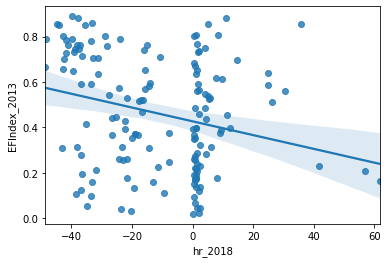

In [331]:
sns.regplot(data=analysis_6, x='hr_2018', y='EFIndex_2013')

#### Iteration #2: EFI 2013 vs HR 2013

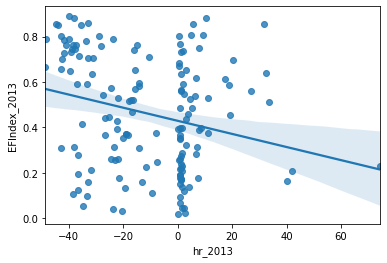

In [332]:
sns.regplot(data=analysis_6, x='hr_2013', y='EFIndex_2013')

# Analysis #7: EFI vs Inequality (ineq)

#### Iteration #1: EFI 2013 vs Inequality 2018

In [333]:
analysis_7=final_df[['EFIndex_2013', 'ineq_2018', 'ineq_2013']].dropna()
analysis_7.corr()

,EFIndex_2013,ineq_2018,ineq_2013
EFIndex_2013,1.000000,-0.382135,-0.399857
ineq_2018,-0.382135,1.000000,0.991763
ineq_2013,-0.399857,0.991763,1.000000


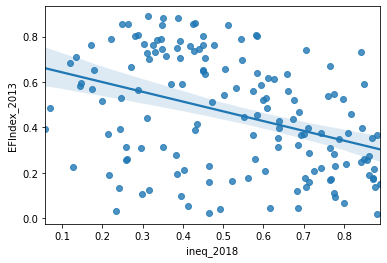

In [334]:
sns.regplot(data=analysis_7, x='ineq_2018', y='EFIndex_2013')

#### Iteration #2: EFI 2013 vs Inequality 2013

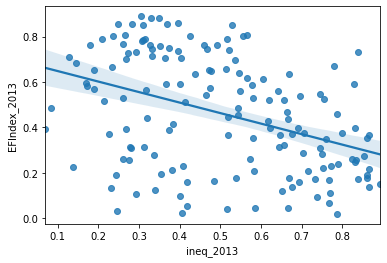

In [335]:
sns.regplot(data=analysis_7, x='ineq_2013', y='EFIndex_2013')

# Analysis #8: EFI vs Internet Users (IU)

#### Iteration #1: EFI 2013 vs IU 2018

In [336]:
analysis_8=final_df[['EFIndex_2013', 'iu_2018', 'iu_2013']].dropna()
analysis_8.corr()

,EFIndex_2013,iu_2018,iu_2013
EFIndex_2013,1.000000,-0.368341,-0.262880
iu_2018,-0.368341,1.000000,0.847679
iu_2013,-0.262880,0.847679,1.000000


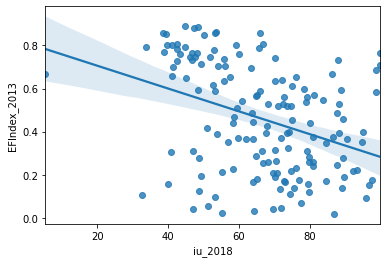

In [338]:
sns.regplot(data=analysis_8, x='iu_2018', y='EFIndex_2013')

#### Iteration #2: EFI 2013 vs IU 2013

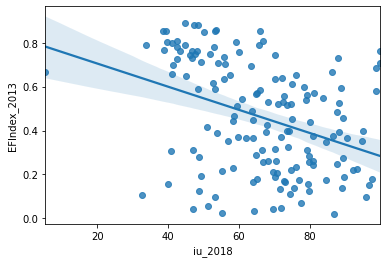

In [339]:
sns.regplot(data=analysis_8, x='iu_2018', y='EFIndex_2013')

# Analysis #9: EFI vs Life Expectancy (LE)

#### Iteration #1: EFI 2013 vs LE 2018

In [340]:
analysis_9=final_df[['EFIndex_2013', 'le_2018', 'le_2013']].dropna()
analysis_9.corr()

,EFIndex_2013,le_2018,le_2013
EFIndex_2013,1.000000,-0.516812,-0.512635
le_2018,-0.516812,1.000000,0.995010
le_2013,-0.512635,0.995010,1.000000


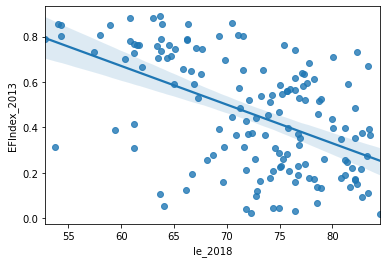

In [342]:
sns.regplot(data=analysis_9, x='le_2018', y='EFIndex_2013')

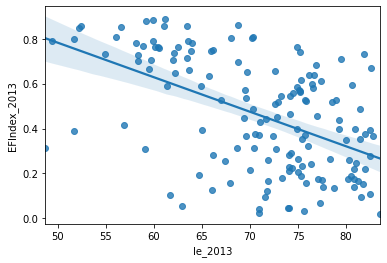

In [343]:
sns.regplot(data=analysis_9, x='le_2013', y='EFIndex_2013')

# Analysis #10: EFI vs Population (POP)

#### Iteration #1: EFI 2013 vs Population 2018

In [400]:
analysis_10=final_df[['Country','EFIndex_2013', 'pop_2018', 'pop_2013']].dropna()
analysis_10.corr()
len(analysis_10)

153

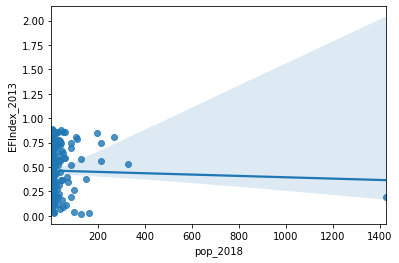

In [401]:
sns.regplot(data=analysis_10, x='pop_2018', y='EFIndex_2013')

Get rid of China outlier so data can be better interpreted

In [402]:
analysis_10.sort_values('pop_2018', ascending=False)
analysis_10.drop([35], inplace=True)

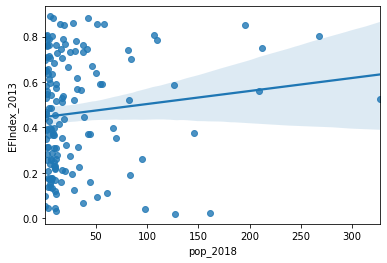

In [403]:
sns.regplot(data=analysis_10, x='pop_2018', y='EFIndex_2013')

#### Iteration #2: EFI 2013 vs Population 2013

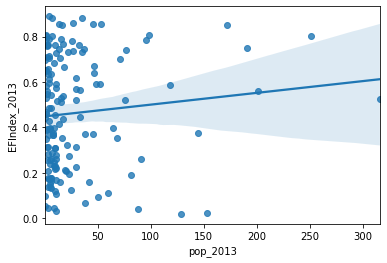

In [404]:
sns.regplot(data=analysis_10, x='pop_2013', y='EFIndex_2013')

# Analysis #11: EFI vs Skilled Labor (SL)

#### Iteration #1: EFI 2013 vs SL 2018

In [405]:
analysis_11=final_df[['Country','EFIndex_2013', 'sl_2018', 'sl_2013']].dropna()
analysis_11.corr()

,EFIndex_2013,sl_2018,sl_2013
EFIndex_2013,1.000000,-0.405429,-0.413789
sl_2018,-0.405429,1.000000,0.938439
sl_2013,-0.413789,0.938439,1.000000


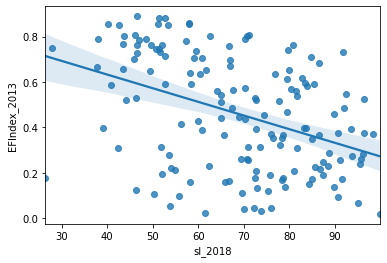

In [406]:
sns.regplot(data=analysis_11, x='sl_2018', y='EFIndex_2013')

#### Iteration #2: EFI 2013 vs SL 2013

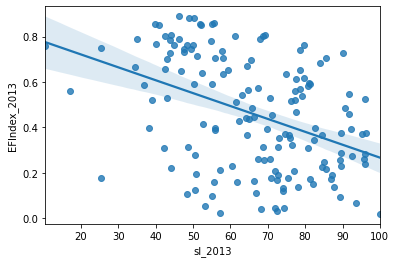

In [407]:
sns.regplot(data=analysis_11, x='sl_2013', y='EFIndex_2013')

# Analysis #12: EFI vs Employment (EMP)

#### Iteration #1: EFI 2013 vs EMP 2018

In [417]:
analysis_12=final_df[['EFIndex_2013', 'emp_2018', 'emp_2013']].dropna()
analysis_12.corr()

,EFIndex_2013,emp_2018,emp_2013
EFIndex_2013,1.000000,0.21956,0.249211
emp_2018,0.219560,1.00000,0.984080
emp_2013,0.249211,0.98408,1.000000


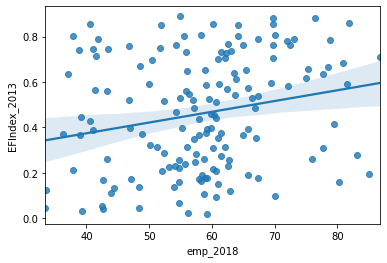

In [418]:
sns.regplot(data=analysis_12, x='emp_2018', y='EFIndex_2013')

#### Iteration #2: EFI 2013 vs EMP 2013

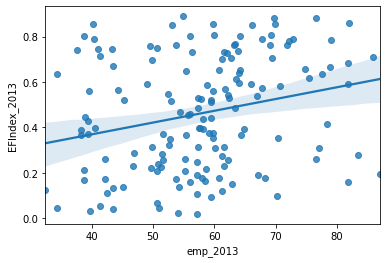

In [419]:
sns.regplot(data=analysis_12, x='emp_2013', y='EFIndex_2013')

# Analysis #13: HDI vs WHR

In [420]:
analysis_13=final_df[['EFIndex_2013', 'Happiness score', 'hdi_2013']].dropna()
analysis_13.corr()

,EFIndex_2013,Happiness score,hdi_2013
EFIndex_2013,1.000000,-0.233367,-0.474222
Happiness score,-0.233367,1.000000,0.779598
hdi_2013,-0.474222,0.779598,1.000000


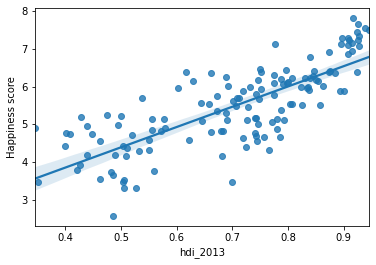

In [421]:
sns.regplot(data=analysis_13, x='hdi_2013', y='Happiness score')

# Analysis #14: EFI vs WHR

In [423]:
analysis_14=final_df[['EFIndex_2013', 'Happiness score']].dropna()
analysis_14.corr()

,EFIndex_2013,Happiness score
EFIndex_2013,1.000000,-0.233367
Happiness score,-0.233367,1.000000


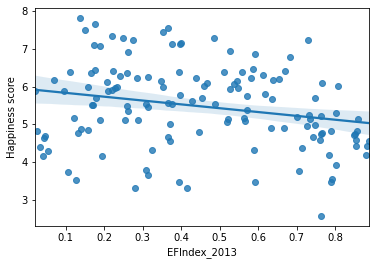

In [424]:
sns.regplot(data=analysis_13, x='EFIndex_2013', y='Happiness score')

#### TO DO:

<ul>
    <li> The final analysis of EFI vs WHR
    <li>   Linear regression models - good enough or expand on it?

# Lasso linear regression

In [262]:
final_df.isna().sum()

HDI Rank (2018)      0
Country              0
hdi_2013             0
hdi_2018             0
EFIndex_2013        35
sy_2013              0
sy_2018              0
gd_2013             24
gd_2018             24
gni_2013             0
gni_2018             0
hr_2013            103
hr_2018            103
ineq_2013           56
ineq_2018           56
iu_2013            118
iu_2018            118
le_2013              0
le_2018              0
pop_2013             0
pop_2018             0
sl_2013            134
sl_2018            134
emp_2013            10
emp_2018            10
ei_2013             62
ei_2018             62
Happiness score     42
dtype: int64

In [285]:
iu_max=df2.iu_2013.max()
hr_max=df2.hr_2013.max()
sl_max=df2.sl_2013.max()
emp_max=df2.emp_2013.max()
ei_max=df2.ei_2013.max()
gd_max=df2.gd_2013.max()
ineq_max=df2.ineq_2013.max()
ineq_max

0.893

In [286]:
df2.iu_2013.fillna(iu_max*df2.hdi_2013, inplace=True)
df2.iu_2018.fillna(iu_max*df2.hdi_2018, inplace=True)
df2.hr_2013.fillna(hr_max*(1-df2.hdi_2013), inplace=True)
df2.hr_2018.fillna(hr_max*(1-df2.hdi_2018), inplace=True)
df2.sl_2013.fillna(sl_max*df2.hdi_2013, inplace=True)
df2.sl_2018.fillna(sl_max*df2.hdi_2018, inplace=True)
df2.emp_2013.fillna(emp_max*df2.hdi_2013, inplace=True)
df2.emp_2018.fillna(emp_max*df2.hdi_2018, inplace=True)
df2.ei_2013.fillna(ei_max*df2.hdi_2013, inplace=True)
df2.ei_2018.fillna(ei_max*df2.hdi_2018, inplace=True)
df2.gd_2013.fillna(gd_max*df2.hdi_2013, inplace=True)
df2.gd_2018.fillna(gd_max*df2.hdi_2018, inplace=True)
df2.ineq_2013.fillna(ineq_max*(1-df2.hdi_2013), inplace=True)
df2.ineq_2018.fillna(ineq_max*(1-df2.hdi_2018), inplace=True)

In [287]:
df2.isnull().sum()

HDI Rank (2018)     0
Country             0
hdi_2013            0
hdi_2018            0
EFIndex_2013       35
sy_2013             0
sy_2018             0
gd_2013             0
gd_2018             0
gni_2013            0
gni_2018            0
hr_2013             0
hr_2018             0
ineq_2013           0
ineq_2018           0
iu_2013             0
iu_2018             0
le_2013             0
le_2018             0
pop_2013            0
pop_2018            0
sl_2013             0
sl_2018             0
emp_2013            0
emp_2018            0
ei_2013             0
ei_2018             0
Happiness score    42
dtype: int64

In [307]:
df_for_lasso=df2.dropna(axis=0)
X=df_for_lasso.drop(['Country', 'Happiness score', 'HDI Rank (2018)', 'hdi_2013', 'hdi_2018'], axis=1)
Y=df_for_lasso['Happiness score']
len(df_for_lasso)

136

In [308]:
regLasso = linear_model.Lasso()

In [309]:
regLasso.fit(X,Y)

Lasso()

In [310]:
d = {X.columns[i] : regLasso.coef_[i] for i in range(0,len(X.columns))}

In [311]:
s = pd.Series(d)

In [312]:
s[s!=0]

gni_2013   -0.000020
gni_2018    0.000057
hr_2013     0.005310
hr_2018     0.009564
iu_2013     0.000789
le_2013     0.002634
pop_2018   -0.000332
ei_2013    -0.000967
dtype: float64

# Decision Tree for predicting happiness

In [313]:
import sklearn.tree

In [428]:
dt = sklearn.tree.DecisionTreeRegressor(max_depth = 2)
dt.fit(X,Y)

DecisionTreeRegressor(max_depth=2)

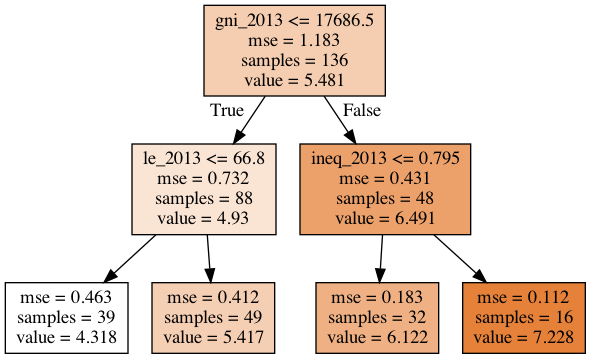

In [429]:
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus

dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

In [316]:
#final_df.corr()

In [317]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

regs = [LinearRegression(), ElasticNet(), DecisionTreeRegressor(), GradientBoostingRegressor(), MLPRegressor()]#, SVR()]

In [318]:
from sklearn.model_selection import KFold

In [320]:
minMAD = 10000000
kf=10
for reg in regs:
    kf = KFold(random_state=0,shuffle=True)
    mad = sklearn.model_selection.cross_val_score(reg,X,Y,\
             cv=kf,scoring='neg_mean_absolute_error').mean()
    # need the lowest scoring for mad
    print (str(reg)[:25] + ' with mad= ' + str(mad) )
    if mad < minMAD:
        minMAD = mad
        bestREG = reg
        
print(kf)
print('***********************************************')
print ('Best Regressor is... ' + str(bestREG)[:25] )
print('**********************')
print ('With MAD Score ' + str(minMAD))

LinearRegression() with mad= -0.5136879212921104
ElasticNet() with mad= -0.5175735186556749
DecisionTreeRegressor() with mad= -0.6356738502386385


/Users/connorcollins/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015798554493947847, tolerance: 0.012801214434853126
  model = cd_fast.enet_coordinate_descent(


GradientBoostingRegressor with mad= -0.4839404817162033


/Users/connorcollins/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/connorcollins/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor() with mad= -508.7260314932473
KFold(n_splits=5, random_state=0, shuffle=True)
***********************************************
Best Regressor is... MLPRegressor()
**********************
With MAD Score -508.7260314932473
